## Load Modules

In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import warnings; warnings.simplefilter('ignore')

from dask.distributed import Client
client = Client()
client

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D
import math
from datetime import timedelta
from operator import attrgetter

## Create a xarray dataset from MITgcm

In [53]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

run = 'partiallayer'


plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#for x in run:
    ## read in data #######
      
data_dir = '/glade/scratch/myoungs/'+run

print(data_dir)
    
   
ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600)
#ds =  open_mdsdataset(data_dir,prefix=['DIAGLayer','DIAG'],delta_t=600)
#                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])
#gridmean = xgcm.Grid(dsmean, periodic=['X'])

print(ds)

/glade/scratch/myoungs/partiallayer
<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 204, YG: 204, Z: 32, Zl: 32, Zp1: 33, Zu: 32, layer_1TH_bounds: 100, layer_1TH_center: 99, layer_1TH_interface: 98, time: 59)
Coordinates:
    iter                 (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                 (time) int64 36586512000 36586944000 ... 36611568000
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 ... 3985000.0 3995000.0
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 ... 2025000.0 2035000.0
  * XG                   (XG) >f4 0.0 10000.0 20000.0 ... 3980000.0 3990000.0
  * YG                   (YG) >f4 0.0 10000.0 20000.0 ... 2020000.0 2030000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -3300.0 -3580.0 -3860.0
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -3440.0 -3720.0 -4000.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -3440.0 -3720.0 -4000.0
  * Zl                   (Zl) >f4 0.0 -10.0 -

## Make new velocity dataset at the center of the grid boxes
I could alternately save netcdfs and then load in as a c-grid, but it seems like the interpolationg would be sufficient

In [54]:
ds1 = ds.assign(UVEL_C = grid.interp(ds.UVEL,'X',boundary='extend'))
ds2 = ds1.assign(VVEL_C = grid.interp(ds.VVEL,'Y',boundary='extend'))
ds3 = ds2.assign(WVEL_C = grid.interp(ds.WVEL,'Z',boundary='extend'))
ds3

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 204, YG: 204, Z: 32, Zl: 32, Zp1: 33, Zu: 32, layer_1TH_bounds: 100, layer_1TH_center: 99, layer_1TH_interface: 98, time: 59)
Coordinates:
    iter                 (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                 (time) int64 36586512000 36586944000 ... 36611568000
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 ... 3985000.0 3995000.0
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 ... 2025000.0 2035000.0
  * XG                   (XG) >f4 0.0 10000.0 20000.0 ... 3980000.0 3990000.0
  * YG                   (YG) >f4 0.0 10000.0 20000.0 ... 2020000.0 2030000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -3300.0 -3580.0 -3860.0
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -3440.0 -3720.0 -4000.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -3440.0 -3720.0 -4000.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -3160.0 -3440.0 -3720.0
    rA                   (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxG                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyG                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    Depth                (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAz                  (YG, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxC                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyC                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAw                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAs                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    drC                  (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    drF                  (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefC               (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefF               (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    hFacC                (Z, YC, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacW                (Z, YC, XG) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacS                (Z, YG, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskC                (Z, YC, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskW                (Z, YC, XG) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskS                (Z, YG, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
  * layer_1TH_bounds     (layer_1TH_bounds) >f4 0.0 0.08080808 ... 7.919192 8.0
  * layer_1TH_center     (layer_1TH_center) float32 0.04040404 ... 7.9595957
  * layer_1TH_interface  (layer_1TH_interface) >f4 0.08080808 ... 7.919192
Data variables:
    LaVH1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    LaHs1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    LaVa1TH              (time, layer_1TH_center, YG, XC) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    LaUH1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    LaUa1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    LaHw1TH              (time, layer_1TH_center, YC, XG) float32 dask.array<chunksize=(1, 99, 204, 400), meta=np.ndarray>
    THETA                (time, Z, YC, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    UVEL                 (time, Z, YC, XG) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    VVEL                 (time, Z, YG, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    WVEL    

## Create a fieldset from xarray dataset 2-D

In [55]:
variables = {'U': 'UVEL_C', 'V': 'VVEL_C','W':'WVEL_C','T':'THETA'}
dimensions = {'time': 'time', 'depth': 'Z','lat': 'YC', 'lon': 'XC' }

fieldset = FieldSet.from_xarray_dataset(ds3, variables, dimensions,mesh='flat', time_periodic=25488000)

## Create halo around to create re-entrant field

In [56]:
fieldset.add_constant('halo_west', fieldset.U.grid.lon[0])
fieldset.add_constant('halo_east', fieldset.U.grid.lon[-1])

fieldset.add_periodic_halo(zonal=True)

def periodicBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle.lon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle.lon -= fieldset.halo_east - fieldset.halo_west

## Create class for temperature sampling

In [57]:
class SampleParticle(JITParticle):         # Define a new particle class
    p = Variable('t', initial=fieldset.T)  # Variable 't' initialised by sampling the pressure
    
def SampleP(particle, fieldset, time):  # Custom function that samples fieldset.P at particle location
    particle.t = fieldset.T[time, particle.depth, particle.lat, particle.lon]

k_sample = pset.Kernel(SampleP)    # Casting the SampleP function to a kernel.

## Create particle set of 1 or 2 particles

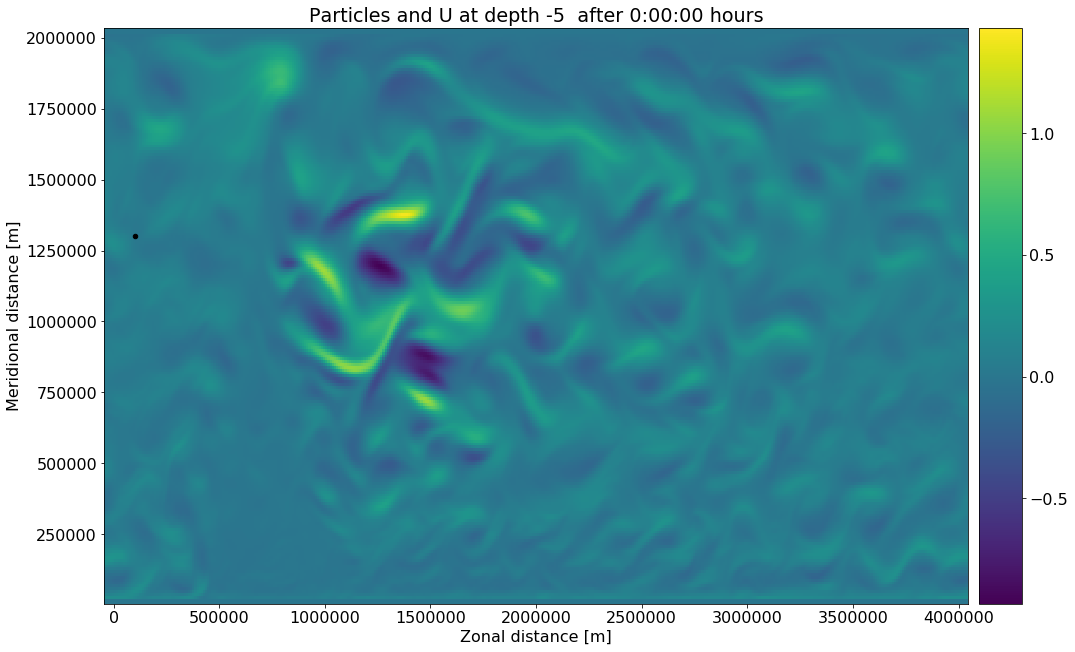

Temp values before execution: [3.243348]


In [58]:
#pset = ParticleSet.from_line(fieldset=fieldset,   # the fields on which the particles are advected
 #                            pclass=JITParticle, # the type of particles (JITParticle or ScipyParticle)
 #                            size=10, start=(5e4, 5e5), finish=(5e4, 1.5e6),
 #                            depth=-1000)   
    
pset = ParticleSet.from_list(fieldset=fieldset, pclass=SampleParticle, lon=[1e5], lat=[1.3e6], depth = -600,time=0)
pset.show(field=fieldset.U)

pset

print('Temp values before execution:', [t.t for t in pset])

## Run particles in time

In [59]:
output_file = pset.ParticleFile(name="EddyParticles.nc", outputdt=timedelta(hours=120)) # the file name and the time step of the outputs

# pset.execute(AdvectionRK4 + pset.Kernel(periodicBC), # add kernel for periodicity

pset.execute(AdvectionRK4_3D + pset.Kernel(periodicBC), #+ k_sample,                 # the kernel (which defines how particles move)
             runtime=timedelta(days=720),    # the total length of the run
             dt=timedelta(minutes=360),      # the timestep of the kernel
             output_file=output_file)

print(pset)
pset.show(field=fieldset.U)

#pset.show(field=fieldset.T, show_time=0)
#print('Temp values after execution:', [t.t for t in pset])

INFO: Compiled SampleParticleAdvectionRK4_3DperiodicBC ==> /var/tmp/pbs.2268604.chadmin1.ib0.cheyenne.ucar.edu/parcels-20804/e4cc02a5c61a140112ed9b0e2c55fe79_0.so
INFO: Temporary output files are stored in out-BMGKBZLD.
INFO: You can use "parcels_convert_npydir_to_netcdf out-BMGKBZLD" to convert these to a NetCDF file during the run.
 40% (25056000.0 of 62208000.0) |###     | Elapsed Time: 0:01:34 ETA:   0:02:07

OutOfTimeError: 0
Particle P[25](lon=2674056.500000, lat=1355422.625000, depth=-562.154541, t=3.243348, time=25056000.000000)
Time: 36611568000.0,	timestep dt: 21600.000000
Field sampled outside time domain at time 36611568000.0. Try setting allow_time_extrapolation to True

## Make movie

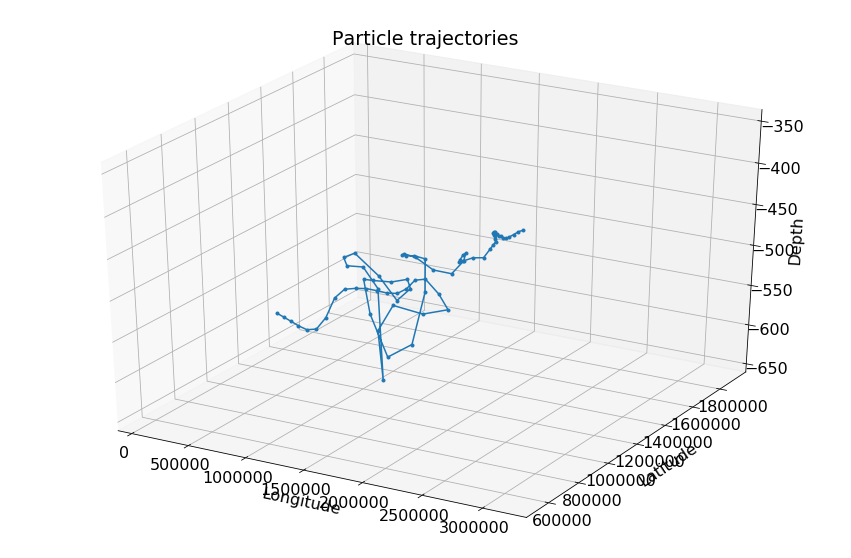

In [44]:
output_file.export()
plotTrajectoriesFile('EddyParticles.nc',mode='3d');

In [25]:
plotTrajectoriesFile('EddyParticles.nc', mode='movie2d_notebook')

## Repeat in 3D?